# 1. Download Dataset from Kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.49G/9.51G [01:12<00:00, 240MB/s]
100% 9.51G/9.51G [01:12<00:00, 140MB/s]


In [ ]:
!unzip '/content/aptos2019-blindness-detection.zip'

Streaming output truncated to the last 5000 lines.
  inflating: test_images/51323e9d2070.png  
  inflating: test_images/515675001b9e.png  
  inflating: test_images/515877da2def.png  
  inflating: test_images/5168ddccea88.png  
  inflating: test_images/5172c056a687.png  
  inflating: test_images/5177461f5339.png  
  inflating: test_images/51910bcb980d.png  
  inflating: test_images/51a3e9b6a1c0.png  
  inflating: test_images/51bbd82feec8.png  
  inflating: test_images/51de5fb8eccd.png  
  inflating: test_images/51e88694c81f.png  
  inflating: test_images/51f0bf8f1544.png  
  inflating: test_images/51f57fb32840.png  
  inflating: test_images/51fa42dc1415.png  
  inflating: test_images/5276ab33b7b0.png  
  inflating: test_images/52a353760f72.png  
  inflating: test_images/531937254e73.png  
  inflating: test_images/5325b1c22c61.png  
  inflating: test_images/53959e0a750b.png  
  inflating: test_images/53be22c72713.png  
  inflating: test_images/5400549bfe76.png  
  inflating: test_images/

# 2. Import Libraries

In [ ]:
!rm -rf /content/*

In [ ]:
!kill -9 -1

In [ ]:
import os
import shutil
import json
import cv2
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn import (
    preprocessing,
    model_selection,
    metrics,
)

In [ ]:
SEED = 42
np.random.seed = SEED
tf.random.set_seed = SEED

# 3. Data Processing

In [ ]:
train_dataset = pd.read_csv('/content/train.csv')
train_dataset.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
classes = ['No DR','Mild','Moderate','Severe','Proliferative DR']

# 3.2 make dataframe for image paths & labels

In [ ]:
PATH = '/content/aptos2019-blindness-detection/train_images/'

file_paths = []
labels = []

for i in range(0,len(train_dataset)):
    file_paths.append(PATH + train_dataset.id_code[i] + '.png')
    labels.append(train_dataset.diagnosis[i])

path_series = pd.Series(file_paths, name='filepath')
label_series = pd.Series(labels, name='label')
training_data = pd.concat([path_series, label_series], axis=1)
training_data.head()

,filepath,label
0,/content/aptos2019-blindness-detection/train_i...,2
1,/content/aptos2019-blindness-detection/train_i...,4
2,/content/aptos2019-blindness-detection/train_i...,1
3,/content/aptos2019-blindness-detection/train_i...,0
4,/content/aptos2019-blindness-detection/train_i...,0


#3.3 make folder hold filtered images

In [ ]:
dest_path = '/content/'

os.mkdir(dest_path + 'filtered_train_images')

In [ ]:
train_source_path = '/content/train_images/'
train_des_path = '/content/filtered_train_images/'

for img in tqdm.tqdm(os.listdir(train_source_path)):
    shutil.copy(train_source_path + img,train_des_path)

100%|██████████| 3662/3662 [01:11<00:00, 51.53it/s]


## 3.4 apply filter for images

In [ ]:
def gaussian_filter(path):
    sigmaX = 15
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gaussian = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), sigmaX), -4, 128)
    gaussian = cv2.resize(gaussian, (224, 224))
    cv2.imwrite(path,gaussian)

In [ ]:
for img in tqdm.tqdm(os.listdir(train_des_path)):
    gaussian_filter(train_des_path + img)

100%|██████████| 3662/3662 [25:04<00:00,  2.43it/s]


In [ ]:
PATH = '/content/filtered_train_images/'

file_paths = []
labels = []

for i in range(0,len(train_dataset)):
    file_paths.append(PATH + train_dataset.id_code[i] + '.png')
    labels.append(train_dataset.diagnosis[i])

path_series = pd.Series(file_paths, name='filepath')
label_series = pd.Series(labels, name='label')
training_data = pd.concat([path_series, label_series], axis=1)
training_data.head()

,filepath,label
0,/content/filtered_train_images/000c1434d8d7.png,2
1,/content/filtered_train_images/001639a390f0.png,4
2,/content/filtered_train_images/0024cdab0c1e.png,1
3,/content/filtered_train_images/002c21358ce6.png,0
4,/content/filtered_train_images/005b95c28852.png,0


## 3.5 Display 25 sample of filtered images

In [ ]:
plt.figure(figsize=(20, 20))
for idx in range(0,25):
    image = cv2.imread(training_data.filepath[idx])
    plt.subplot(5,5,idx+1)
    plt.imshow(image)
plt.show()

## 3.6 Splitting Data

In [ ]:
mask = np.random.rand(len(training_data)) < 0.8
train = training_data[mask]
test = training_data[~mask]

print('Training Data Size :- ',train.shape)
print('Testing Data Size :- ',test.shape)

Training Data Size :-  (2951, 2)
Testing Data Size :-  (711, 2)


In [ ]:
x = train.filepath
y = train.label

# 4. Modeling

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (5,5), padding="same", input_shape=(224,224,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128, (5,5), padding="same", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128, (5,5), padding="same", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128, (5,5), padding="same", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(256, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(128,activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(len(classes), activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     409728    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       409728    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)       0

In [ ]:
path = '/content/train.csv'

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)


kfold = model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

# Variable for keeping count of split we are executing
j = 0

model_history = []

# K-fold Train and test for each split
for train_idx, val_idx in tqdm.tqdm(list(kfold.split(x,y))):
    x_train_df = training_data.iloc[train_idx]
    x_valid_df = training_data.iloc[val_idx]

    j+=1

    training_set = train_datagen.flow_from_dataframe(dataframe=x_train_df, directory=path,
                                                 x_col="filepath", y_col="label",
                                                 class_mode="raw",
                                                 target_size=(224,224), batch_size=32)

    validation_set = validation_datagen.flow_from_dataframe(dataframe=x_valid_df, directory=path,
                                                 x_col="filepath", y_col="label",
                                                 class_mode="raw",
                                                 target_size=(224,224), batch_size=32)

    early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', mode='max', restore_best_weights=True)

    history = model.fit(training_set,validation_data=validation_set,epochs = 10,callbacks=[early_stopping])

    model_history.append(history)


  0%|          | 0/5 [00:00<?, ?it/s]

Found 2360 validated image filenames.
Found 591 validated image filenames.
Epoch 1/10
74/74 [==============================] - 61s 612ms/step - loss: 1.1657 - accuracy: 0.5436 - val_loss: 0.9831 - val_accuracy: 0.6345
Epoch 2/10
74/74 [==============================] - 36s 489ms/step - loss: 0.9887 - accuracy: 0.6640 - val_loss: 0.9901 - val_accuracy: 0.6548
Epoch 3/10
74/74 [==============================] - 39s 521ms/step - loss: 0.9247 - accuracy: 0.6767 - val_loss: 0.9261 - val_accuracy: 0.6667
Epoch 4/10
74/74 [==============================] - 36s 490ms/step - loss: 0.8948 - accuracy: 0.6907 - val_loss: 0.9360 - val_accuracy: 0.6785
Epoch 5/10
74/74 [==============================] - 36s 491ms/step - loss: 0.8808 - accuracy: 0.6928 - val_loss: 0.9278 - val_accuracy: 0.6582
Epoch 6/10
74/74 [==============================] - 37s 503ms/step - loss: 0.8563 - accuracy: 0.7068 - val_loss: 0.9191 - val_accuracy: 0.6802
Epoch 7/10
74/74 [==============================] - 36s 491ms/step 

 20%|██        | 1/5 [07:07<28:31, 427.80s/it]

Found 2361 validated image filenames.
Found 590 validated image filenames.
Epoch 1/10
74/74 [==============================] - 46s 626ms/step - loss: 0.8142 - accuracy: 0.7031 - val_loss: 0.7313 - val_accuracy: 0.7390
Epoch 2/10
74/74 [==============================] - 37s 496ms/step - loss: 0.8225 - accuracy: 0.7145 - val_loss: 0.7256 - val_accuracy: 0.7271
Epoch 3/10
74/74 [==============================] - 37s 501ms/step - loss: 0.8226 - accuracy: 0.6997 - val_loss: 0.7443 - val_accuracy: 0.7305
Epoch 4/10
74/74 [==============================] - 36s 486ms/step - loss: 0.7867 - accuracy: 0.7179 - val_loss: 0.7376 - val_accuracy: 0.7254
Epoch 5/10
74/74 [==============================] - 36s 486ms/step - loss: 0.7855 - accuracy: 0.7154 - val_loss: 0.7299 - val_accuracy: 0.7356
Epoch 6/10
74/74 [==============================] - 38s 516ms/step - loss: 0.7721 - accuracy: 0.7264 - val_loss: 0.7533 - val_accuracy: 0.7203


 40%|████      | 2/5 [11:34<16:39, 333.20s/it]

Found 2361 validated image filenames.
Found 590 validated image filenames.
Epoch 1/10
74/74 [==============================] - 36s 490ms/step - loss: 0.8088 - accuracy: 0.6997 - val_loss: 0.7079 - val_accuracy: 0.7559
Epoch 2/10
74/74 [==============================] - 37s 500ms/step - loss: 0.8051 - accuracy: 0.7107 - val_loss: 0.7167 - val_accuracy: 0.7339
Epoch 3/10
74/74 [==============================] - 36s 485ms/step - loss: 0.8022 - accuracy: 0.7099 - val_loss: 0.7129 - val_accuracy: 0.7542
Epoch 4/10
74/74 [==============================] - 36s 489ms/step - loss: 0.7921 - accuracy: 0.7137 - val_loss: 0.7393 - val_accuracy: 0.7288
Epoch 5/10
74/74 [==============================] - 38s 513ms/step - loss: 0.7748 - accuracy: 0.7205 - val_loss: 0.7277 - val_accuracy: 0.7542
Epoch 6/10
74/74 [==============================] - 36s 488ms/step - loss: 0.7780 - accuracy: 0.7145 - val_loss: 0.7047 - val_accuracy: 0.7644
Epoch 7/10
74/74 [==============================] - 38s 505ms/step 

 60%|██████    | 3/5 [18:05<11:58, 359.35s/it]

Found 2361 validated image filenames.
Found 590 validated image filenames.
Epoch 1/10
74/74 [==============================] - 38s 511ms/step - loss: 0.7160 - accuracy: 0.7310 - val_loss: 0.6920 - val_accuracy: 0.7508
Epoch 2/10
74/74 [==============================] - 37s 496ms/step - loss: 0.7211 - accuracy: 0.7323 - val_loss: 0.6902 - val_accuracy: 0.7475
Epoch 3/10
74/74 [==============================] - 36s 491ms/step - loss: 0.7079 - accuracy: 0.7298 - val_loss: 0.7013 - val_accuracy: 0.7576
Epoch 4/10
74/74 [==============================] - 37s 496ms/step - loss: 0.7032 - accuracy: 0.7357 - val_loss: 0.6885 - val_accuracy: 0.7424
Epoch 5/10
74/74 [==============================] - 37s 498ms/step - loss: 0.6873 - accuracy: 0.7471 - val_loss: 0.7278 - val_accuracy: 0.7475
Epoch 6/10
74/74 [==============================] - 37s 499ms/step - loss: 0.6799 - accuracy: 0.7501 - val_loss: 0.7541 - val_accuracy: 0.7458
Epoch 7/10
74/74 [==============================] - 37s 496ms/step 

 80%|████████  | 4/5 [23:13<05:39, 339.37s/it]

Found 2361 validated image filenames.
Found 590 validated image filenames.
Epoch 1/10
74/74 [==============================] - 37s 501ms/step - loss: 0.7295 - accuracy: 0.7277 - val_loss: 0.5754 - val_accuracy: 0.7932
Epoch 2/10
74/74 [==============================] - 37s 500ms/step - loss: 0.7119 - accuracy: 0.7382 - val_loss: 0.5782 - val_accuracy: 0.8017
Epoch 3/10
74/74 [==============================] - 38s 512ms/step - loss: 0.7091 - accuracy: 0.7421 - val_loss: 0.5584 - val_accuracy: 0.7983
Epoch 4/10
74/74 [==============================] - 37s 494ms/step - loss: 0.6910 - accuracy: 0.7438 - val_loss: 0.5819 - val_accuracy: 0.7831
Epoch 5/10
74/74 [==============================] - 37s 494ms/step - loss: 0.6783 - accuracy: 0.7501 - val_loss: 0.5543 - val_accuracy: 0.8000
Epoch 6/10
74/74 [==============================] - 37s 495ms/step - loss: 0.6765 - accuracy: 0.7476 - val_loss: 0.5824 - val_accuracy: 0.7847
Epoch 7/10
74/74 [==============================] - 36s 492ms/step 

100%|██████████| 5/5 [27:40<00:00, 332.04s/it]


## 1. Model Activity Chart

In [ ]:
acc,val_acc,loss,val_loss = [],[],[],[]
for idx in range(0,len(model_history)):
    acc.extend(model_history[idx].history['accuracy'])
    val_acc.extend(model_history[idx].history['val_accuracy'])

    loss.extend(model_history[idx].history['loss'])
    val_loss.extend(model_history[idx].history['val_loss'])

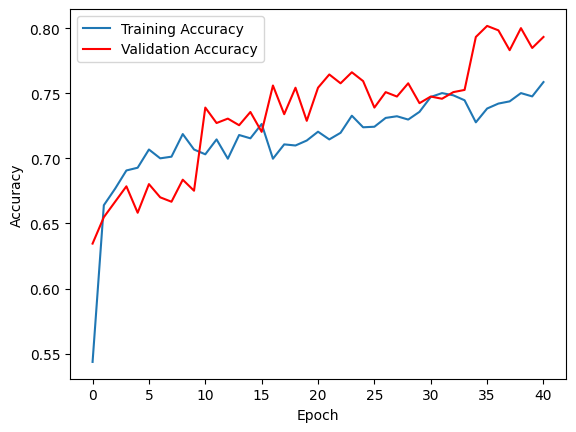

In [ ]:
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, color='red', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

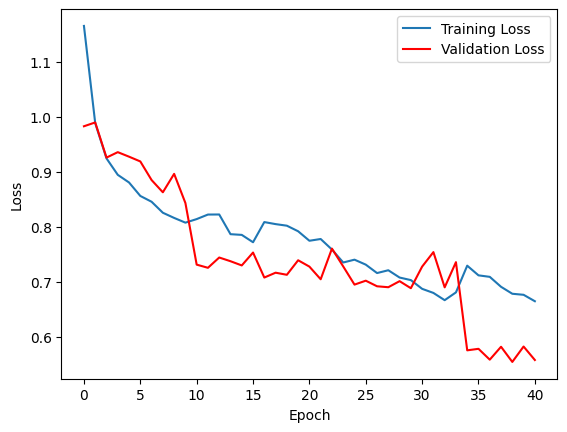

In [ ]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2.Save Progress

In [ ]:
model.save("/content/diabetic_retina_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_infos = {
  "loss": loss,
  "accuracy": acc,
  "val_loss": val_loss,
  "val_acc" : val_acc
}

with open("/content/model_history.json", "w") as outfile:
    json.dump(model_infos, outfile)

## 2.Model Evaluation

In [ ]:
test_path = "/content/train.csv"

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_dataframe(dataframe=test, directory=path,
                                                 x_col="filepath", y_col="label",
                                                 class_mode="raw",
                                                 target_size=(224,224), batch_size=32)

Found 711 validated image filenames.


In [ ]:
model.evaluate(test_set)

23/23 [==============================] - 3s 131ms/step - loss: 0.6809 - accuracy: 0.7553


[0.6809490919113159, 0.75527423620224]

In [ ]:
# After processing the files and before the end of your script
import shutil

# Mount Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

# Example destination folder in Google Drive
dest_folder = '/content/drive/My Drive/dataset/'

Mounted at /content/drive


#Host the website

In [ ]:
import tensorflow as tf
import cv2
import numpy as np

# Load the trained model
model = tf.keras.models.load_model('/content/diabetic_retina_model.h5')

# Function to preprocess the uploaded image
def preprocess_image(image):
    image = cv2.resize(image, (224, 224))
    # Add any other preprocessing steps here
    return image

In [ ]:
%%writefile app.py
import streamlit as st

st.title('Deep Diabetic Retinopathy Detection')

st.sidebar.title('Upload Images')
left_image = st.sidebar.file_uploader('Upload Left Eye Image', type=['jpg', 'png'])
right_image = st.sidebar.file_uploader('Upload Right Eye Image', type=['jpg', 'png'])

if left_image and right_image:
    left_image_data = preprocess_image(cv2.imread(left_image))
    right_image_data = preprocess_image(cv2.imread(right_image))

    # Perform inference using the model
    left_eye_result = model.predict(np.expand_dims(left_image_data, axis=0))
    right_eye_result = model.predict(np.expand_dims(right_image_data, axis=0))

    # Display results
    st.write('### Left Eye Result:', left_eye_result)
    st.write('### Right Eye Result:', right_eye_result)

Writing app.py


In [ ]:
!pip install pyngrok --upgrade

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [ ]:
!pip install streamlit pillow tensorflow

In [ ]:
import streamlit as st
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd

# Load the trained model
model = tf.keras.models.load_model('/content/diabetic_retina_model.h5')

# Function to preprocess the uploaded image
def preprocess_image(image):
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Ensure correct color format
    image = image / 255.0  # Normalize pixel values
    return image

st.title('Deep Diabetic Retinopathy Detection')

# Adding slogans
st.write('''
Your eyes, your best tool, take care of them

Your eyes are in your hands

Love your eyes, love your future
''')

# Path to your image
image_path = '/content/retina.jpg'

# Display the image
st.image(image_path, caption='The Retina', use_column_width=True)

st.sidebar.title('Upload Images')
left_image = st.sidebar.file_uploader('Upload Left Eye Image', type=['jpg', 'png'])
right_image = st.sidebar.file_uploader('Upload Right Eye Image', type=['jpg', 'png'])

if left_image and right_image:
    left_image_data = preprocess_image(cv2.imdecode(np.fromstring(left_image.read(), np.uint8), 1))
    right_image_data = preprocess_image(cv2.imdecode(np.fromstring(right_image.read(), np.uint8), 1))

    # Perform inference using the model
    left_eye_result = model.predict(np.expand_dims(left_image_data, axis=0))
    right_eye_result = model.predict(np.expand_dims(right_image_data, axis=0))

    # Convert numeric labels to class names
    class_mapping = {0: 'No DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferative DR'}
    left_eye_class = class_mapping[np.argmax(left_eye_result)]
    right_eye_class = class_mapping[np.argmax(right_eye_result)]

    # Display results
    st.write('### Left Eye Result:', left_eye_class)
    st.write('#### Probabilities:')
    left_prob_df = pd.DataFrame({ 'Class': class_mapping.values(), 'Probability': left_eye_result[0] })
    st.write(left_prob_df)

    st.write('### Right Eye Result:', right_eye_class)
    st.write('#### Probabilities:')
    right_prob_df = pd.DataFrame({ 'Class': class_mapping.values(), 'Probability': right_eye_result[0] })
    st.write(right_prob_df)

    # Show Result button
    if st.button('Get Results'):
        left_eye_disease = 'No Disease' if left_eye_class == 'No DR' else 'Diabetic Retinopathy'
        right_eye_disease = 'No Disease' if right_eye_class == 'No DR' else 'Diabetic Retinopathy'

        result_text = ""
        result_text += f"Left eye is prone to {left_eye_disease}.\n"
        result_text += f"Highest Probability for Left Eye: {left_prob_df['Probability'].max()}\n\n"

        result_text += f"Right eye is prone to {right_eye_disease}.\n"
        result_text += f"Highest Probability for Right Eye: {right_prob_df['Probability'].max()}\n\n"

        if left_eye_disease == 'No Disease' and right_eye_disease == 'No Disease':
            result_text += "Both eyes are not prone to any disease.\n"
        elif left_eye_disease == 'Diabetic Retinopathy' and right_eye_disease == 'Diabetic Retinopathy':
            result_text += "Both eyes are prone to Diabetic Retinopathy.\n"
        elif left_eye_disease == 'No Disease' and right_eye_disease == 'Diabetic Retinopathy':
            result_text += "Left eye is not prone to any disease, but right eye is prone to Diabetic Retinopathy.\n"
        elif left_eye_disease == 'Diabetic Retinopathy' and right_eye_disease == 'No Disease':
            result_text += "Right eye is not prone to any disease, but left eye is prone to Diabetic Retinopathy.\n"

        st.markdown(result_text)

In [ ]:
!streamlit run app.py &>/content/logs.txt &

In [ ]:
!curl https://loca.lt/mytunnelpassword

34.123.82.6

In [ ]:
!npx localtunnel --port 8501